In [1]:
using Random

In [2]:
using Plots

# Evaluating the 2D Ising model partition function

## Labelling configurations

To sum over all $2^N$ configurations of $N$ spins we need to somehow enumerate them. One way of assigning integers to configurations is simply to choose an ordering of the spins, which immediately gives us a binary integer.

We can slightly abuse Julia's BitArray for this purpose. BitArrays are arrays of bits stored in memory as a series of 64-bit unsigned integers, as we can confirm by looking at the source https://github.com/JuliaLang/julia/blob/v1.1.0/base/bitarray.jl. If we restrict ourselves to $N \le 64$ we can enumerate configurations by incrementing the integer used as storage for the BitArray.

In [3]:
ba = falses(8,8)

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

The integers are stored in a field called "chunks". Since we asked for an array with 64 bits, only one chunk is used.

In [4]:
size(ba.chunks)

(1,)

It has the initial value 0.

In [5]:
ba.chunks[1]

0x0000000000000000

Let's print out the first few configurations!

In [6]:
ba.chunks[1] = 1
ba

8×8 BitArray{2}:
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

In [7]:
ba.chunks[1] = 2
ba

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

In [8]:
ba.chunks[1] = 3
ba

8×8 BitArray{2}:
  true  false  false  false  false  false  false  false
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

In [9]:
ba.chunks[1] = 4
ba

8×8 BitArray{2}:
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
  true  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false
 false  false  false  false  false  false  false  false

## Summing over configurations

To evaluate the partition function exactly we must sum over all configurations.
There are quite a few configurations of an 8x8 array of spins.

In [10]:
2.0^64

1.8446744073709552e19

We will need to work with fewer if we want our sums to complete in a reasonable time. How about 25?

In [11]:
2^(5^2)

33554432

Much better. 

In [12]:
ba_sm = falses(5,5)

5×5 BitArray{2}:
 false  false  false  false  false
 false  false  false  false  false
 false  false  false  false  false
 false  false  false  false  false
 false  false  false  false  false

In [13]:
ba_sm.chunks[1] = 2^25-1

33554431

In [14]:
ba_sm

5×5 BitArray{2}:
 true  true  true  true  true
 true  true  true  true  true
 true  true  true  true  true
 true  true  true  true  true
 true  true  true  true  true

## Computing weights

Now, how to evaluate the weight of a configuration? Let's write a funcion that takes a configuration in the form of a BitArray and returns the weight.

In [15]:
spin(b::Bool) = Float64(2 * b - 1)

spin (generic function with 1 method)

Create a wrapper function to do the timing (this avoids counting spurious memory allocations).

In [16]:
time_spin(x) = @time spin(x)

time_spin (generic function with 1 method)

In [17]:
time_spin(false)

  0.000002 seconds


-1.0

In [18]:
function ising_weight_2D_PBC(c::AbstractMatrix{Bool}, h::Float64, Jx::Float64, Jy::Float64, β::Float64)::Float64
    Ly,Lx = size(c)
    
    en = 0.0
    @inbounds @fastmath for k in 1:Lx, j in 1:Ly
        s = spin(c[j,k])
        en -= h * s
        en -= Jx * s * spin(c[j,mod1(k+1, Lx)])
        en -= Jy * s * spin(c[mod1(j+1, Ly),k])
    end
    
    exp(-en * β)
end

ising_weight_2D_PBC (generic function with 1 method)

Let's benchmark this. First let's make a benchmarking function!

In [19]:
time_ising_weight(b) = @time ising_weight_2D_PBC(b, 1.0, 1.0, 1.0, 1/2.269)

time_ising_weight (generic function with 1 method)

Run it once first to get it compiled.

In [20]:
time_ising_weight(ba_sm)

  0.000003 seconds


2.266003258686664e14

Now time it.

In [21]:
time_ising_weight(ba_sm)

  0.000002 seconds


2.266003258686664e14

In [22]:
let b = bitrand(1000,1000)
    time_ising_weight(b)
end

  0.016035 seconds


1.0311077281872751e160

In [23]:
# Try with array of Bools...
let b = rand(Bool, 1000,1000)
    @show typeof(b)
    time_ising_weight(b)
end

typeof(b) = Array{Bool,2}
  0.014193 seconds


1.2437968586878357e-69

Our function does not allocate any memory, which is as it should be. This suggests it will be reasonably fast. See https://docs.julialang.org/en/v1/manual/performance-tips/.

## Computing the partition function
Let's try evaluating $Z(h, J_x, J_y)$.

In [24]:
function ising_Z_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" # Although it would take a *long* time, our implementation would do 64!
    c = falses(Ly,Lx)
    Z = 0.0
    for j in 0:2^N-1
        c.chunks[1] = j # Set the bit configuration of the BitArray c (j must be in 0:2^(N-1) for N=length(c))
        Z += ising_weight_2D_PBC(c, h, Jx, Jy, β)
    end
    
    Z
end

ising_Z_2D_PBC (generic function with 1 method)

In [25]:
time_ising_Z(Lx, Ly) = @time ising_Z_2D_PBC(Lx,Ly,0.0,1.0,1.0,1/2.269)

time_ising_Z (generic function with 1 method)

In [26]:
time_ising_Z(4,4)

  0.017020 seconds (2 allocations: 144 bytes)


5.514089467214674e6

We have a constant number of allocations, coming from creating the BitArray c.

$20$ spins is a practical upper-limit for a fairly quick computation.

In [27]:
time_ising_Z(5,4)

  0.342717 seconds (2 allocations: 144 bytes)


2.2869633871033853e8

## Aside: Alternative to manipulating BitArray.chunks

We could avoid messing with BitArray.chunks by writing a function to convert an integer into a configuration:

In [28]:
function int_to_conf!(v, i::Integer)
    for j=1:length(v)
        i,b = divrem(i,2) # Repeatedly divide by 2. Remainder is the bit value at position j.
        v[j] = b
    end
    v
end

int_to_conf! (generic function with 1 method)

In [29]:
time_int_to_conf!(v,i) = @time int_to_conf!(v,i)

time_int_to_conf! (generic function with 1 method)

Test it!

In [30]:
let N = 3
    v = zeros(Int8, N)
    for i=0:2^N-1
        time_int_to_conf!(v, i)
        @show v
    end
end

  0.000002 seconds
v = Int8[0, 0, 0]
  0.000003 seconds
v = Int8[1, 0, 0]
  0.000002 seconds
v = Int8[0, 1, 0]
  0.000002 seconds
v = Int8[1, 1, 0]
  0.000002 seconds
v = Int8[0, 0, 1]
  0.000002 seconds
v = Int8[1, 0, 1]
  0.000001 seconds
v = Int8[0, 1, 1]
  0.000002 seconds
v = Int8[1, 1, 1]


In [31]:
function ising_Z_2D_PBC_v2(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = zeros(Bool, Ly,Lx)
    Z = 0.0
    for j in 0:2^N-1
        int_to_conf!(c, j)
        Z += ising_weight_2D_PBC(c, h, Jx, Jy, β)
    end
    
    Z
end

ising_Z_2D_PBC_v2 (generic function with 1 method)

In [32]:
time_ising_Z_v2(Lx, Ly) = @time ising_Z_2D_PBC_v2(Lx,Ly,0.0,1.0,1.0,1/2.269)

time_ising_Z_v2 (generic function with 1 method)

In [33]:
time_ising_Z_v2(5,4)

  0.393742 seconds (1 allocation: 112 bytes)


2.2869633871033853e8

## Evaluation of some thermodynamic variables

  1.803475 seconds (201 allocations: 14.938 KiB)


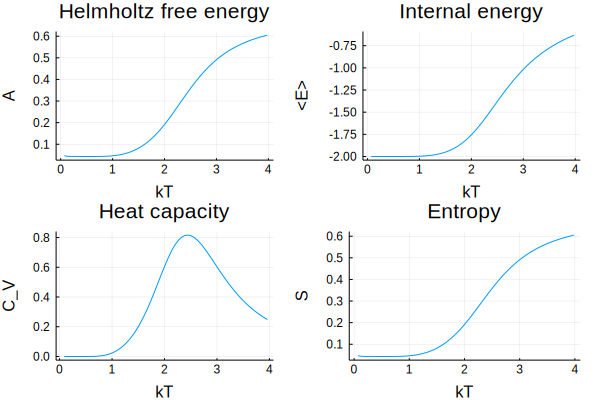

In [34]:
let Lx = 4, Ly = 4, h = 0.0, Jx = 1.0, Jy = 1.0, kTs = range(0.01, 4.0, length=100)
    N = Lx * Ly
    βs = 1 ./ kTs
    @time logZs = Float64[log(ising_Z_2D_PBC(Lx,Ly,h,Jx,Jy,β)) for β in βs]
    As = -kTs .* logZs ./ N
    
    kTmids = kTs[1:end-1] + diff(kTs) ./ 2
    βmids = βs[1:end-1] + diff(βs) ./ 2
    
    ens = -diff(logZs) ./ diff(βs) ./ N
    p_U = plot(kTmids, ens, title="Internal energy", xlabel="kT", ylabel="<E>")
    
    cs =  diff(ens) ./ diff(kTmids)
    p_C = plot(kTs[2:end-1], cs, title="Heat capacity", xlabel="kT", ylabel="C_V")
    
    S = (ens .- (As[1:end-1] + As[2:end])./2) .* βmids
    p_S = plot(kTmids, S, title="Entropy", xlabel="kT", ylabel="S")
    
    p_A = plot(kTmids, S, title="Helmholtz free energy", xlabel="kT", ylabel="A")
    
    plot(p_A, p_U, p_C, p_S, layout=4, legend=false)
end

## Evaluation of expectation values

Here we will compute the magnetization. First define the magnetization of a configuration:

In [35]:
function ising_mag_2D_PBC(c::BitArray{2})::Float64
    Ly,Lx = size(c)
    N = Lx * Ly
    Nup = count(c)
    
    (2Nup - N) / N
end

ising_mag_2D_PBC (generic function with 1 method)

We can use this, together with the weight function, to compute the expectation value of the magnetization:

In [36]:
function ising_m_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = falses(Ly,Lx)
    Z = 0.0
    M = 0.0
    for j in 0:2^N-1
        c.chunks[1] = j
        w = ising_weight_2D_PBC(c, h, Jx, Jy, β)
        m = ising_mag_2D_PBC(c)
        M += w * m
        Z += w
    end
    
    M / Z
end

ising_m_2D_PBC (generic function with 1 method)

Plot as a function of the external field $h$.

  2.049353 seconds (201 allocations: 14.938 KiB)


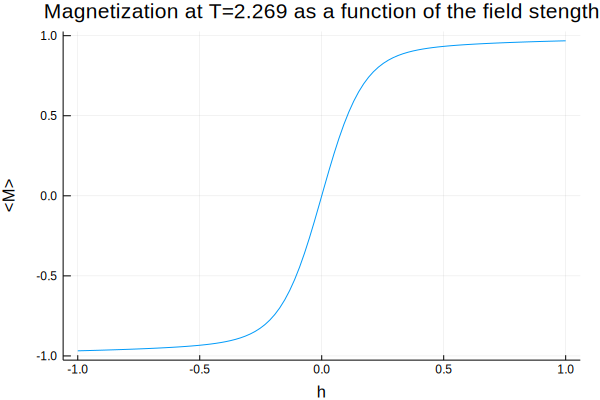

In [37]:
let Lx = 4, Ly = 4, T = 2.269, Jx = 1.0, Jy = 1.0, hs = range(-1.0, 1.0, length=100)
    N = Lx * Ly
    @time ms = Float64[ising_m_2D_PBC(Lx,Ly,h,Jx,Jy,1/T) for h in hs]
    plot(
        hs, ms, 
        title="Magnetization at T=$T as a function of the field stength",
        xlabel="h", ylabel="<M>",
        legend=false
    )
end

Plot as a function of the temperature $T$.

  1.924477 seconds (201 allocations: 14.938 KiB)


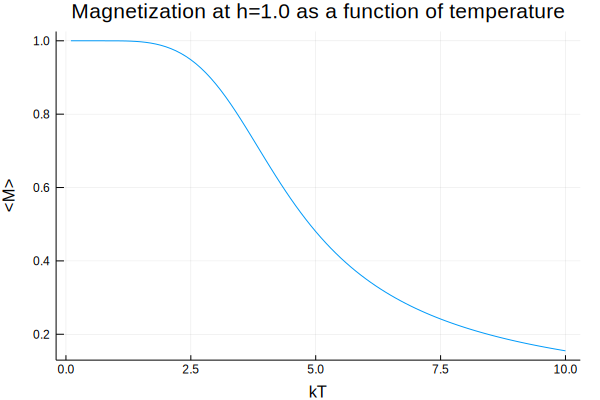

In [38]:
let Lx = 4, Ly = 4, h = 1.00, Jx = 1.0, Jy = 1.0, kTs = range(0.1, 10.0, length=100)
    N = Lx * Ly
    @time ms = Float64[ising_m_2D_PBC(Lx,Ly,h,Jx,Jy,1/kT) for kT in kTs]
    plot(
        kTs, ms, 
        title="Magnetization at h=$h as a function of temperature",
        xlabel="kT", ylabel="<M>",
        legend=false
    )
end

## Probability distribution

We can also compute the probability distribution, the density of states, and other interesting quantities. Let's define a function that returns the probability of each configuration, together with the magnetization and the value of Z.

In [39]:
function ising_pd_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = falses(Ly,Lx)
    Ws = zeros(2^N)
    Ms = zeros(2^N)
    for j in 0:2^N-1
        c.chunks[1] = j
        W = ising_weight_2D_PBC(c, h, Jx, Jy, β)
        M = ising_mag_2D_PBC(c)
        Ws[j+1] = W
        Ms[j+1] = M
    end
    Z = sum(Ws)
    
    P = Ws ./ Z #normalize the weights to probabilities
    
    P, Ms, Z
end

ising_pd_2D_PBC (generic function with 1 method)

  0.021419 seconds (9 allocations: 1.500 MiB)
sum(P) = 0.9999999999999998


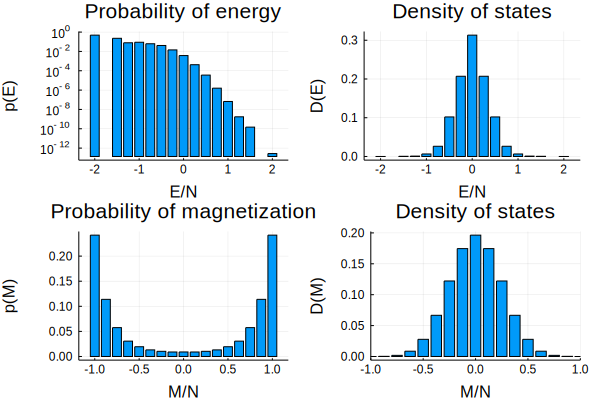

In [47]:
let Lx = 4, Ly = 4, T = 2.269, Jx = 1.0, Jy = 1.0, h = 0.0
    N = Lx * Ly
    @time P, Ms, Z = ising_pd_2D_PBC(Lx,Ly,h,Jx,Jy,1/T)
    
    #Sort the configurations by probability
    srt = sortperm(P, rev=true)
    P = P[srt]
    Ms = Ms[srt]
    
    @show sum(P)
    Ws = P * Z
    Es = -log.(Ws) * T
    
    Es_unique = sort(unique(Es))
    
    PE = zeros(length(Es_unique))
    for j in 1:length(Es_unique)
        PE[j] = sum(P[Es .== Es_unique[j]])
    end
    
    p_pE = bar(
        Es_unique/N, PE,
        title="Probability of energy",
        xlabel="E/N", ylabel="p(E)",
        yscale=:log10
    )
    
    
    D = zeros(length(Es_unique))
    for j in 1:length(Es_unique)
        D[j] = count(Es .== Es_unique[j]) / length(Es)
    end

    p_D = bar(
        Es_unique / N, D,
        title="Density of states",
        xlabel="E/N", ylabel="D(E)"
    )
    

    Ms_unique = sort(unique(Ms))
    PM = zeros(length(Ms_unique))
    for j in 1:length(Ms_unique)
        PM[j] = sum(P[Ms .== Ms_unique[j]])
    end

    p_pM = bar(
        Ms_unique, PM,
        title="Probability of magnetization",
        xlabel="M/N", ylabel="p(M)"
    )
    
    
    DM = zeros(length(Ms_unique))
    for j in 1:length(Ms_unique)
        DM[j] = count(Ms .== Ms_unique[j]) / length(Ms)
    end
    
    p_DM = bar(
        Ms_unique, DM,
        title="Density of states",
        xlabel="M/N", ylabel="D(M)",
        xlim=(-1,+1)
    )
    
    plot(p_pE, p_D, p_pM, p_DM, legend=false)
end